## libraries

In [4]:
import xcast as xc
import datetime as dt
import numpy as np
from pathlib import Path
import xarray as xr
import os
import time
import cartopy.crs as ccrs
import cartopy.feature as cf
import matplotlib.pyplot as plt
import glob

import practical_helper_functions as helper

# automatically reloads the configuration file once updated and saved so you don't have to restart the kernel
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:
1073/60

17.883333333333333

## directories

In [6]:
# setup the folder where you want to work for this project
# either type in the location, or place this notebook in the folder where you want your project to live and set project_dir = os.getcwd()
project_dir = os.getcwd()#"/Users/katie/Desktop/trial_pacisl" 

#make subdirectores to organize your work within the project if they don't already exist
practical_data_dir = os.path.join(project_dir, 'practical_data')
nmme_nc_dir = '/cpc/int_desk/pac_isl/data/processed/nmme/nc_files'
cmorph_nc_dir = '/cpc/int_desk/pac_isl/data/processed/cmorph/nc_files'
chirps_nc_dir = '/cpc/int_desk/pac_isl/data/processed/chirps/nc_files'

## constants

In [7]:
initial_dates = [(2023, 7,1), (2023, 8, 1), (2023, 9, 1), (2023, 10, 1), (2023, 11,1), (2023, 12,1),
                 (2024, 1, 1), (2024, 2, 1), (2024, 3, 1), (2024, 4, 1), (2024, 5, 1), (2024, 6, 1)]

#predictor extent, zone over which you want to train your model
predictor_extent = {
        'west':  120,
        'east': 210,  
        'north': 10,  
        'south': -30
      }

#where you want to target your final analysis
predictand_extent = {
        'west':  130,
        'east': 206,  
        'north': 10,  
        'south': -20
      }

### get all target / initialization periods for each initialization date

In [8]:
initial_months, initial_month_names, target_seasons, target_months = [], [], [], []
 
for i in initial_dates:
    leads = [['1', '3'],['2', '4'], ['3','5']]
    initial_month = dt.datetime(*i).month
    initial_months.append(initial_month)
    initial_month_names.append(helper.number_to_month_name_dictionary[initial_month])
    target_month = []
    target_seas = []
    for l in leads:
        target_low = helper.number_to_month_name_dictionary[(initial_month + float(l[0]))%12]
        target_mid = helper.number_to_month_name_dictionary[(initial_month + float(l[0])+1)%12]
        target_high = helper.number_to_month_name_dictionary[(initial_month + float(l[1]))%12]
        target_seas.append('-'.join([target_low, target_high]))
        target_month.append(target_low[0] + target_mid[0] + target_high[0])
    target_seasons.append(target_seas)
    target_months.append(target_month)

### setting up nmme data for analysis
these netcdf files when processed are counting forwards, 32 years for single season analysis (1991-2022), 75 years for three season analysis (25 years times 3 seasons); set up this time as the base time to align the other files as the one 'T' index for each initialized month

#### one season setup

<xarray.Dataset>
Dimensions:  (M: 1, Y: 179, X: 360, T: 32)
Coordinates:
  * M        (M) object 'NMME'
  * Y        (Y) float32 -89.0 -88.0 -87.0 -86.0 -85.0 ... 86.0 87.0 88.0 89.0
  * X        (X) float32 -180.0 -179.0 -178.0 -177.0 ... 176.0 177.0 178.0 179.0
  * T        (T) datetime64[ns] 2024-06-20 2025-06-20 ... 2054-06-20 2055-06-20
    L        int64 3
Data variables:
    precip   (M, T, Y, X) float64 0.2717 0.2723 0.2731 ... 0.5499 0.5499 0.5502

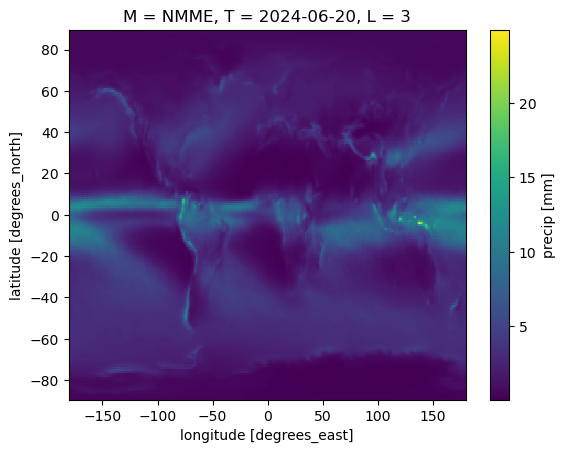

In [13]:
# read in hindcast and forecast data
training_length = 'one_seas'
oneseas_hindcast_data_im, oneseas_forecast_data_im = [], []
for i, im in enumerate(initial_month_names):
    hindcast_data, forecast_data = [], []
    for t, target in enumerate(target_months[i]):
        gcm_hindcast_download_file = '{}*.nc'.format('_'.join([im, 'ld' + leads[t][0], training_length, 'NMME_hind']))
        gcm_forecast_download_file = '{}*.nc'.format('_'.join([im, 'ld' + leads[t][0], training_length, 'NMME_fcst']))
        g = xr.open_dataset(glob.glob(os.path.join(nmme_nc_dir, gcm_hindcast_download_file))[0])
        f = xr.open_dataset(glob.glob(os.path.join(nmme_nc_dir, gcm_forecast_download_file))[0])
        g = helper.prep_names(g, helper.coordinate_conversion).expand_dims({'M':['NMME']}).dropna(dim = 'Y')
        f = helper.prep_names(f, helper.coordinate_conversion).expand_dims({'M':['NMME']}).dropna(dim = 'Y')
        g = g.assign_coords({'L':t+1})
        f = f.assign_coords({'L':t+1})
        hindcast_data.append(g)
        forecast_data.append(f)
    #create one dataset across all lead times of interest
    forecast_data = xr.concat(forecast_data, dim = 'L')
    #check all hindcast years are available for all lead times and only keep dataset with intersecting years
    hindcast_data = xr.concat(hindcast_data, dim = 'L')

    oneseas_hindcast_data_im.append(hindcast_data)
    oneseas_forecast_data_im.append(forecast_data)
#check the data looks right
g.isel(T=0).precip.plot()
g

In [6]:
for i, im in enumerate(initial_month_names):
    oneseas_forecast_data_im[i].to_netcdf(os.path.join(practical_data_dir, '_'.join([im, 'oneseas_NMME_fcst_precip.nc'])))
    oneseas_hindcast_data_im[i].to_netcdf(os.path.join(practical_data_dir, '_'.join([im, 'oneseas_NMME_hcst_precip.nc'])))

#### three season setup

<xarray.Dataset>
Dimensions:  (M: 1, Y: 166, X: 360, T: 75)
Coordinates:
  * M        (M) object 'NMME'
  * Y        (Y) float32 -76.0 -75.0 -74.0 -73.0 -72.0 ... 86.0 87.0 88.0 89.0
  * X        (X) float32 -180.0 -179.0 -178.0 -177.0 ... 176.0 177.0 178.0 179.0
  * T        (T) datetime64[ns] 2024-06-20 2025-06-20 ... 2097-06-20 2098-06-20
    L        int64 3
Data variables:
    precip   (M, T, Y, X) float64 1.174 1.185 1.191 ... 0.4645 0.5018 0.539

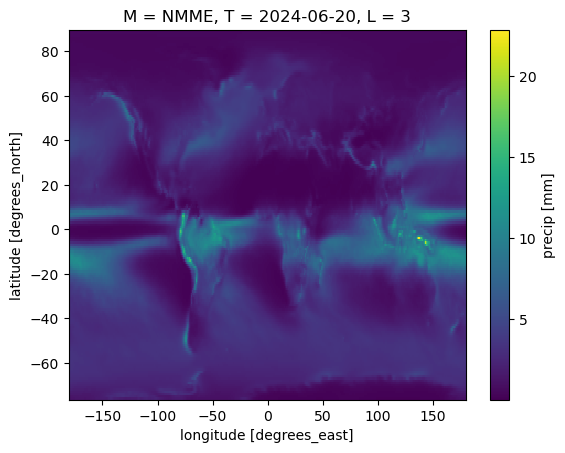

In [9]:
# read in hindcast and forecast data
training_length = 'three_seas'
threeseas_hindcast_data_im, threeseas_forecast_data_im = [], []
for i, im in enumerate(initial_month_names):
    hindcast_data, forecast_data = [], []
    for t, target in enumerate(target_months[i]):
        gcm_hindcast_download_file = '{}*.nc'.format('_'.join([im, 'ld' + leads[t][0], training_length, 'NMME_hind']))
        gcm_forecast_download_file = '{}*.nc'.format('_'.join([im, 'ld' + leads[t][0], training_length, 'NMME_fcst']))
        g = xr.open_dataset(glob.glob(os.path.join(nmme_nc_dir, gcm_hindcast_download_file))[0])
        f = xr.open_dataset(glob.glob(os.path.join(nmme_nc_dir, gcm_forecast_download_file))[0])
        g = helper.prep_names(g, helper.coordinate_conversion).expand_dims({'M':['NMME']}).dropna(dim = 'Y')
        f = helper.prep_names(f, helper.coordinate_conversion).expand_dims({'M':['NMME']}).dropna(dim = 'Y')
        g = g.assign_coords({'L':t+1})
        f= f.assign_coords({'L':t+1})
        hindcast_data.append(g)
        forecast_data.append(f)
    #create one dataset across all lead times of interest
    forecast_data = xr.concat(forecast_data, dim = 'L')
    #check all hindcast years are available for all lead times and only keep dataset with intersecting years
    hindcast_data = xr.concat(hindcast_data, dim = 'L')
    
    #crop model data to predictor extent
    hindcast_360 = helper.adjust_longitude_to_360(hindcast_data, 'X').sortby('Y', ascending = True).sortby('X', ascending = True)
    hindcast_comp = hindcast_360.sel(X= slice(predictor_extent['west'], predictor_extent['east']),
                            Y = slice(predictor_extent['south'], predictor_extent['north']))
    forecast_360 = helper.adjust_longitude_to_360(forecast_data, 'X').sortby('Y', ascending = True).sortby('X', ascending = True)
    forecast_comp = forecast_360.sel(X= slice(predictor_extent['west'], predictor_extent['east']),
                        Y = slice(predictor_extent['south'], predictor_extent['north']))

    threeseas_hindcast_data_im.append(hindcast_comp)
    threeseas_forecast_data_im.append(forecast_comp)
#check the data looks right
g.isel(T=0).precip.plot()
g

In [ ]:
for i, im in enumerate(initial_month_names):
    threeseas_forecast_data_im[i].to_netcdf(os.path.join(practical_data_dir, '_'.join([im, 'threeseas_NMME_fcst_precip.nc'])))
    threeseas_hindcast_data_im[i].to_netcdf(os.path.join(practical_data_dir, '_'.join([im, 'threeseas_NMME_hcst_precip.nc'])))

### setting up cmorph data for analysis
this data was processed in the same manner as nmme, so should have the exact same time stamp, but calculate the intersecting T values to be absolutely certain before combining across leads

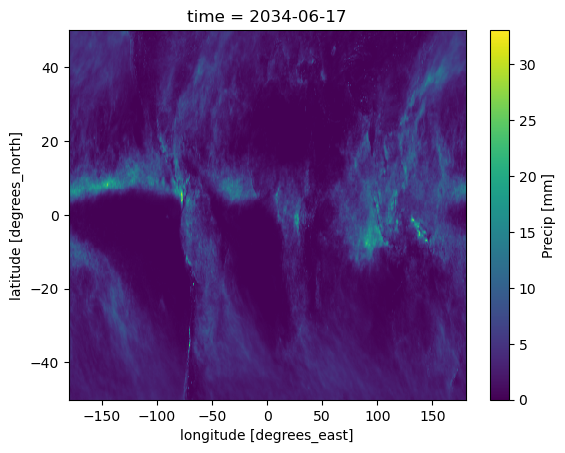

In [11]:
threeseas_cmorph_im = []
for i, im in enumerate(initial_month_names):
    obs_leads = []
    for t, target in enumerate(target_months[i]):
        obs_file = '{}*.nc'.format('_'.join([im, 'ld' + str(t + 1), 'CMORPH']))
        Y_raw = xr.open_dataset(glob.glob(os.path.join(cmorph_nc_dir, obs_file))[0])
        Y = helper.prep_names(Y_raw, helper.coordinate_conversion)
        Y = getattr(Y, [i for i in Y.data_vars][0])
        Y = Y.expand_dims({'L':[t+1], 'M':[0]}).to_dataset(name = 'precip')
        obs_leads.append(Y)
    obs_leads = xr.concat(obs_leads, dim = 'L')
    
    #crop observations to target zone
    obs_360 = helper.adjust_longitude_to_360(obs_leads, 'X').sortby('Y', ascending = True).sortby('X', ascending = True)
    obs_comp = obs_360.sel(X= slice(predictand_extent['west'], predictand_extent['east']),
                            Y = slice(predictand_extent['south'], predictand_extent['north']))
    threeseas_cmorph_im.append(obs_comp)
Y_raw.isel(time=10).precip.plot()

In [12]:
for i, im in enumerate(initial_month_names):
    threeseas_cmorph_im[i].to_netcdf(os.path.join(practical_data_dir, '_'.join([im, 'threeseas_CMORPH_precip.nc'])))

### setting up chirps data for analysis
only keep years available to NMME: 1991-2022
label all years as the NMME years to keep it simple (given that netcdf is counting forwards) once the years extracted are correct

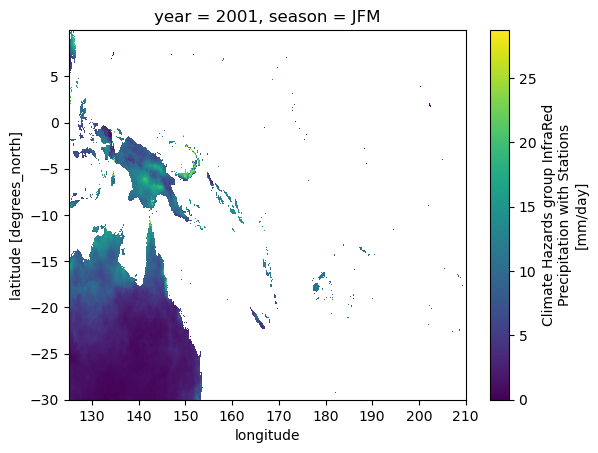

In [14]:
oneseas_ucsb_im = []
for i, im in enumerate(initial_month_names):
    obs_leads = []
    obs_file = '{}*.nc'.format('CHIRPS_pac-islands')
    Y_raw = xr.open_dataset(glob.glob(os.path.join(chirps_nc_dir, obs_file))[0])
    years_of_interest = helper.getYears(1991,2022)
    Y_raw = Y_raw.sel(year=Y_raw.year.isin(years_of_interest))
    for t, target in enumerate(target_months[i]):
        # obs_file = '{}*.nc'.format('_'.join([target, 'UCSB0p05_pac-islands']))
        Y_seas = Y_raw.sel(season=target)
        Y = helper.prep_names(Y_seas, helper.coordinate_conversion)
        Y = getattr(Y, [i for i in Y.data_vars][0])
        Y = Y.expand_dims({'L':[t+1], 'M':[0]}).drop('season')
        Y = Y.to_dataset(name = 'precip')
        model = oneseas_hindcast_data_im[i].isel(L=t)
        #update observations to have same time dimension as the model hindcasts
        Y_update = []
        for oneyear, year in enumerate(Y.T.values):
            Y_year = Y.sel(T=year)
            Y_year = Y_year.assign_coords({'T': model.isel(T=oneyear).T.values})
            Y_update.append(Y_year)
        Y_update = xr.concat(Y_update, dim = 'T')
        
        #crop observations to target zone
        obs_360 = helper.adjust_longitude_to_360(Y_update, 'X').sortby('Y', ascending = True).sortby('X', ascending = True)
        obs_comp = obs_360.sel(X= slice(predictand_extent['west'], predictand_extent['east']),
                                Y = slice(predictand_extent['south'], predictand_extent['north']))
        obs_leads.append(obs_comp)
    obs_leads = xr.concat(obs_leads, dim = 'L')
    oneseas_ucsb_im.append(obs_leads)
Y_raw.isel(year=10, season=0).precip.plot()

In [15]:
for i, im in enumerate(initial_month_names):
    oneseas_ucsb_im[i].to_netcdf(os.path.join(practical_data_dir, '_'.join([im, 'oneseas_CHIRPS_precip.nc'])))

### set up individual model data for comparison

In [113]:
raw_models = ['CFSv2', 'CanCM4i','GEM5_NEMO', 'GFDL_SPEAR', 'NCAR_CCSM4', 'NASA_GEOS5v2']#NCAR_CESM1 is messed up, missing 2022 and 2023, but has 2024

CFSv2
1982-01-01
1982-02-01
1982-03-01
1982-04-01
1982-05-01
1982-06-01
1982-07-01
1982-08-01
1982-09-01
1982-10-01
1982-11-01
1982-12-01
<xarray.Dataset>
Dimensions:       (lon: 360, lat: 181, T: 384, L: 3)
Coordinates:
  * lon           (lon) float32 0.0 1.0 2.0 3.0 4.0 ... 356.0 357.0 358.0 359.0
  * lat           (lat) float32 90.0 89.0 88.0 87.0 ... -87.0 -88.0 -89.0 -90.0
    initial_time  (T) float32 372.0 384.0 396.0 408.0 ... 731.0 743.0 755.0
  * L             (L) int64 1 2 3
  * T             (T) object 1991-01-01 1992-01-01 ... 2021-12-01 2022-12-01
    M             <U5 'CFSv2'
Data variables:
    fcst          (T, L, lat, lon) float32 dask.array<chunksize=(1, 1, 181, 360), meta=np.ndarray>
Attributes:
    creation_date:  Fri Apr 20 09:23:44 2018
CanCM4i
1982-01-01
1982-02-01
1982-03-01
1982-04-01


KeyboardInterrupt: 

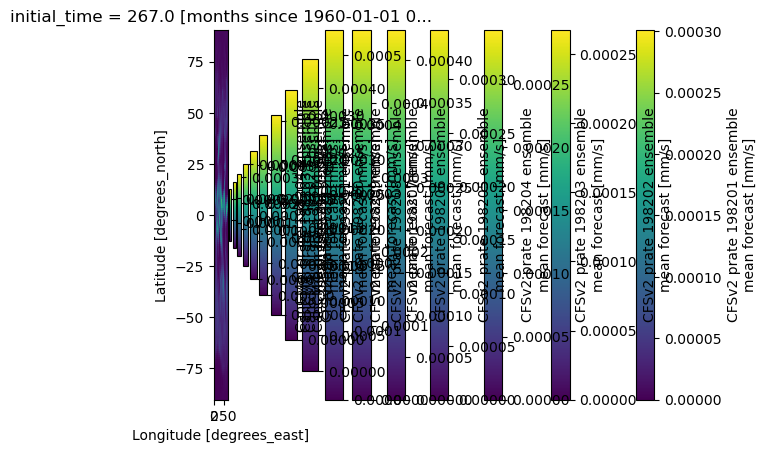

In [123]:
from datetime import date, timedelta
from dateutil.relativedelta import relativedelta
# Function to convert months to dates
def convert_months_to_dates(months, start_date):
    return [start_date + relativedelta(months=+m) for m in months]

model_hcsts = []
for r in raw_models:
    print(r)
    one_model_times = []
    for im in ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12']:
        hcst_dir = '/cpc/nmme/' + r + '/hcst_new/' + im + '0100/' + r + '.prate.*.ENSMEAN.fcst.nc'

        #because xarray can't easily interpret 'months from 1960-01-01', run the following to manually create T and L variables from targets/initialized months
        raw_model_im = xr.open_mfdataset(hcst_dir, decode_times=False)
        start_date = date(1960,1,1)
        dates_of_interest = convert_months_to_dates(raw_model_im['initial_time'].values, start_date)
        print(dates_of_interest[0])
        #keep 1,2,3 because 0 is the same month as initialization
        leads = [1,2,3]
        raw_model_leads = xr.concat([raw_model_im.isel(target=l).assign_coords({'L':l}) for l in leads], dim = 'L').drop('target')
        raw_model_leads.isel(L=0,initial_time=0).fcst.plot()
        if r in ['CFSv2', 'CanCM4i', 'NCAR_CCSM4', 'NASA_GEOS5v2']:
            low_index = 9
            high_index = 40
        #don't use NCAR_CESM1 until 2022 gets added back to the dataset, otherwise 2024 is getting treated as 2022
        #the following models have hindcasts beginning in 1991
        elif r in ['GEM5_NEMO', 'GFDL_SPEAR', 'NCAR_CESM1']:
            low_index = 0
            high_index = 31
        raw_model_times = xr.concat([raw_model_leads.isel(initial_time=t).assign_coords({'T':dates_of_interest[t]}) for t in list(range(low_index, high_index+1))], dim = 'T')
        raw_model_times = raw_model_times.assign_coords({'M': r})
        one_model_times.append(raw_model_times)
    one_model_times = xr.concat(one_model_times, dim = 'T')
    model_hcsts.append(one_model_times)
    print(one_model_times)
model_hcsts = xr.concat(model_hcsts, dim = 'M')
model_hcsts = model_hcsts.rename({'lon':'X', 'lat':'Y'})
#crop model data to predictor extent
model_slice = model_hcsts.sortby('Y', ascending = True).sel(X= slice(predictor_extent['west'], predictor_extent['east']),
                        Y = slice(predictor_extent['south'], predictor_extent['north']))
model_slice

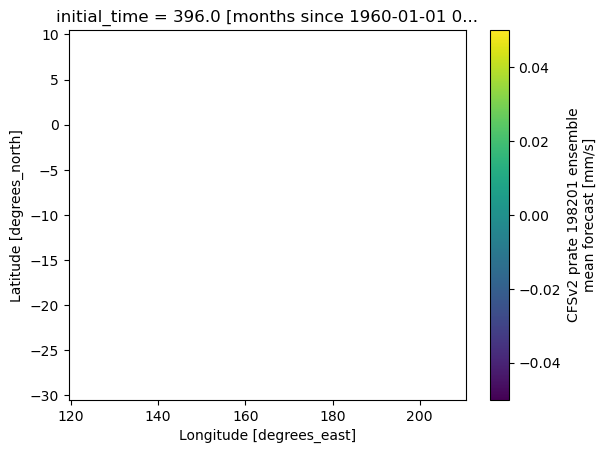

In [121]:
model_slice.isel(L=1,T=2,M=1).fcst.plot()